# Miami Housing Price Prediction using Decision Trees
Kristy Hamlin <br>
07/13/23 <br>

<b>OBJECTIVE:</b> In this Jupyter Notebook, I will use Python to implement a Machine Learning model that uses Decision Trees to estimate Miami Housing Prices using the 2016 dataset from Kaggle (see References section). I will also include brief notes in markdown cells to indicate what I am doing and why. <br><br>
<b>NOTE:</b> I would like to acknowledge that, as a beginner to programming and to Machine Learning, I used LinkedIn Learning to learn more about how to create ML models in Python using Jupyter Notebooks. I found the course <i>Machine Learning with Python: Foundations</i> with Frederick Nwanganga to be very helpful for me to understand how to implement code for many of the concepts we learned in class. Therefore, you may notice that I use similar methods or a similar workflow, and I have included a citation to this LinkedIn Learning course below in the "References" section.

# 1. Importing and Exploring Data
In this section, I will import the data and explore it.

In [235]:
import pandas as pd
prices = pd.read_csv("miami-housing-ORIGINAL.csv")
prices.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


In [236]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

As I noted in my Interim Report, it seems that there are no null values in any of the fields. However, it still seems our dataset has a very high dimensionality. In Machine Learning, the "curse of dimensionality" suggests that having too high a number of features can be detrimental to the model. Therefore we will start to look at some of the fields and consider whether they can be removed. <br><br>
The field structure_quality is a categorical value that is supposed to indicate the quality of the house. I am interested in seeing how many houses of each quality there are:

In [237]:
prices[['structure_quality']].value_counts()

structure_quality
4                    7625
2                    4110
5                    2002
1                     179
3                      16
dtype: int64

I am shocked that there is such a low proportion of structures rated 1 and 3. I have assumed that "5" indicates a high quality structure, but reading the description on Kaggle does not confirm this. I will look at the average price of each category to confirm my understanding.

In [238]:
prices.groupby('structure_quality')[['SALE_PRC']].mean()

,SALE_PRC
structure_quality,
1,1.626397e+05
2,2.696723e+05
3,1.847250e+06
4,3.825710e+05
5,7.431893e+05


Except for group 3, groups 1-5 follow a steady increase in sale price, confirming that a rating of 5 indicates a high-quality home. Given that group 3 is very unusual in that it has only 16 houses and in that the price of these houses is unexpectedly high, I may remove these instances. 

In [239]:
%matplotlib inline

<Axes: xlabel='OCEAN_DIST', ylabel='SALE_PRC'>

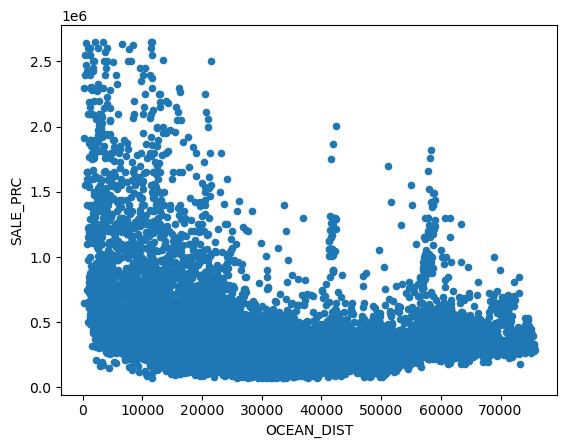

In [240]:
prices.plot(kind = 'scatter', x = 'OCEAN_DIST', y = 'SALE_PRC')

<Axes: xlabel='age', ylabel='SALE_PRC'>

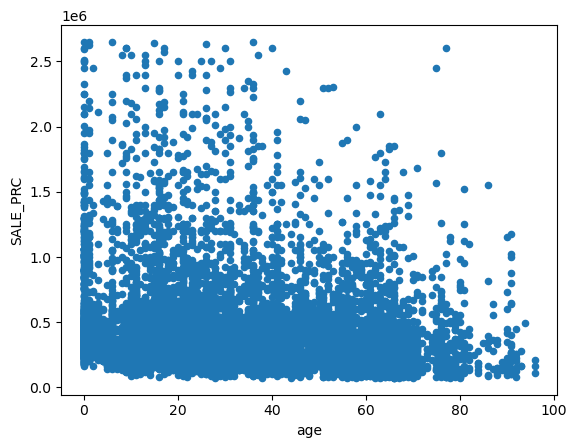

In [241]:
prices.plot(kind = 'scatter', x = 'age', y = 'SALE_PRC')

<Axes: xlabel='CNTR_DIST', ylabel='SALE_PRC'>

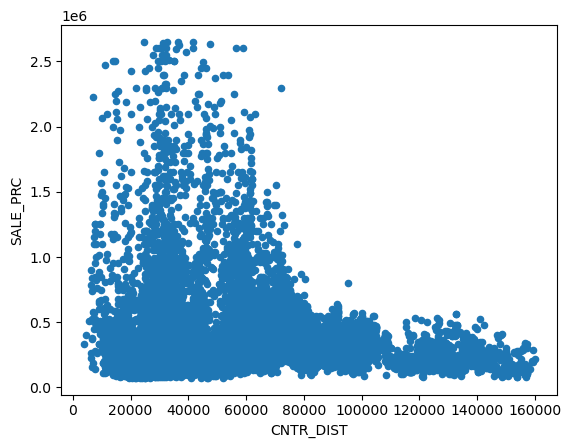

In [242]:
prices.plot(kind = 'scatter', x = 'CNTR_DIST', y = 'SALE_PRC')

As I expected, age, distance to the ocean, and distance to the city seem to correlate well with price. I did not expect distance to the city to have the visually cleanest correlation, but I suppose this makes sense because I hate West Kendall and I would rather be homeless than live in West Kendall. As a note, 160,000 feet is approximately 30 miles, meaning this map probably extends near or into Homestead depending on exactly where it considers the center of downtown to be. 

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

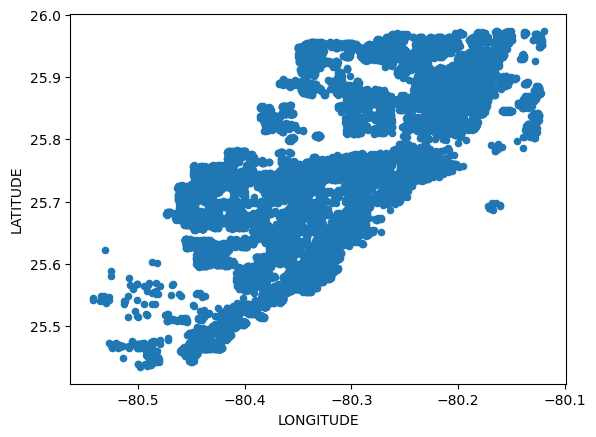

In [243]:
prices.plot(kind = 'scatter', x = 'LONGITUDE', y = 'LATITUDE')

Entertainingly, plotting the longitude and latitude clearly shows us the coast, downtown, kendall, pinecrest, and west kendall areas. I believe the dots farthest to the right are probably South Beach and Key Biscayne on the bottom. <br><br>
For the time being, we will proceed to data preprocessing.

# 2. Data Preprocessing 
### Part 1: Reducing Dimensions
In this section, I will prepare the data for analysis. I plan to reduce the dimensionality by removing fields that I do not believe will contribute much to the accuracy of the model, as well as remove outliers and other strange data. 

I will begin by dropping the latitude and longitude columns. Based on the map, we may expect southward homes to have a lower price because we know everyone hates West Kendall and Homestead. However, I expect this correlation to be redundant because this will also be captured by CNTR_DIST, the distance to downtown. Therefore we should be able to safety drop these columns.

In [244]:
prices = prices.drop('LONGITUDE', axis=1)
prices = prices.drop('LATITUDE', axis=1)

I will call .head() again to make sure the columns are gone.

In [245]:
prices.head()

,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


Parcelno can also be dropped. The Kaggle information tell us that only a very small number of houses appear multiple times. <br><br>

In [246]:
prices = prices.drop('PARCELNO', axis=1)

I suspect that month sold can also be dropped, but I will check to make sure there is no obvious correlation first.

In [247]:
month_prices = prices.pivot(columns = 'month_sold', values = 'SALE_PRC')
month_prices

month_sold,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440000.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,349000.0,NaN,NaN,NaN
2,NaN,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,988000.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,755000.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13927,NaN,NaN,NaN,275000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13928,NaN,NaN,NaN,NaN,340000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13929,NaN,NaN,NaN,NaN,NaN,NaN,287500.0,NaN,NaN,NaN,NaN,NaN
13930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315000.0,NaN,NaN,NaN,NaN


<Axes: >

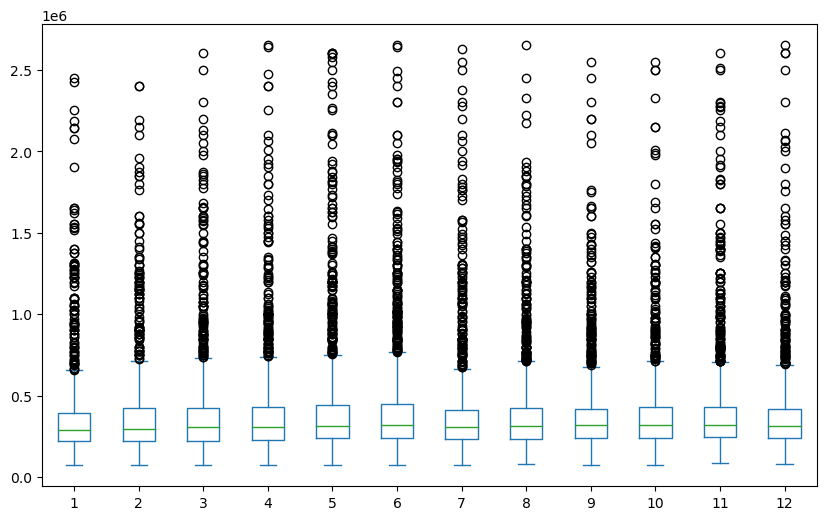

In [248]:
month_prices.plot(kind = 'box', figsize = (10,6))

As expected, the price distribution is very similar regardless of the month of sale. I will drop this column.

In [249]:
prices = prices.drop('month_sold', axis=1)

I suspect avno60plus (a field indicating if a house has noise from nearby airports) may be dropped, or if a small subset of houses is unusual in that has a high level of noise and this throws off the price, we may benefit from removing those rows.

In [250]:
prices[['avno60plus']].value_counts()

avno60plus
0             13724
1               208
dtype: int64

In [251]:
prices.groupby('avno60plus')[['SALE_PRC']].mean()

,SALE_PRC
avno60plus,
0,400997.298018
1,330308.052885


<Axes: >

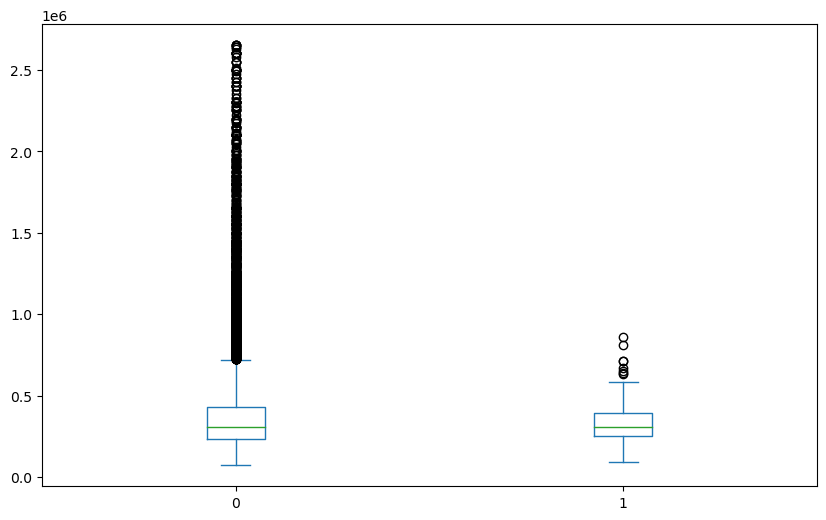

In [252]:
av60_prices = prices.pivot(columns = 'avno60plus', values = 'SALE_PRC')
av60_prices.plot(kind = 'box', figsize = (10,6))

We can see that the majority of the data has a similar spread, although we can also see that none of the most expensive houses seem to be located near noisy airports. However, I believe we can drop this field without removing those rows and not be in trouble. 

In [253]:
prices = prices.drop('avno60plus', axis=1)

I suspect distance to the nearest highway might not be a field that influences price much. This is because being close to a highway contributes to noise, but it may be offset by convenience given how being located near a highway can be extremely convenient in Miami. Let's take a look:

<Axes: xlabel='HWY_DIST', ylabel='SALE_PRC'>

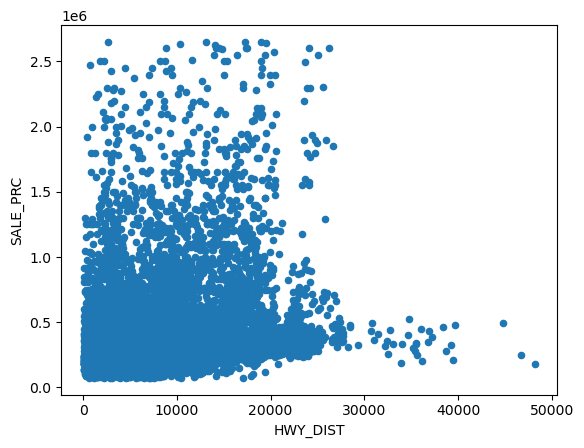

In [254]:
prices.plot(kind = 'scatter', x = 'HWY_DIST', y = 'SALE_PRC')

Since the majority of the distribution does not seem to be correlated, I will drop HWY_DIST. 

In [255]:
prices = prices.drop('HWY_DIST', axis=1)

I expect that distance to the city center will be a much stronger predictor of price than distance to the nearest sub-center. Let us see how strong the correlation is between price and sub-center distance:

<Axes: xlabel='SUBCNTR_DI', ylabel='SALE_PRC'>

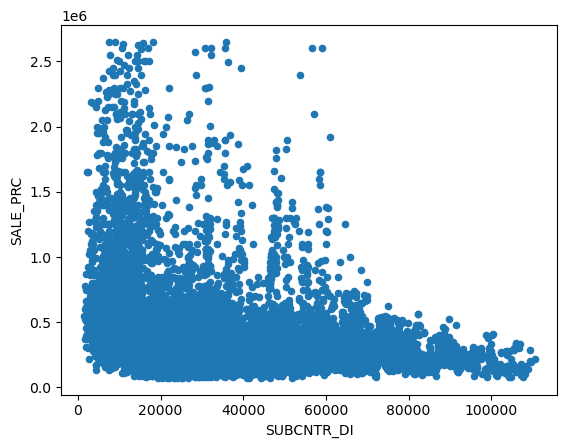

In [256]:
prices.plot(kind = 'scatter', x = 'SUBCNTR_DI', y = 'SALE_PRC')

Nevermind, I will keep this field because the correlation looks pretty clear. <br><br>

I will also take a closer look at distance to the nearest rail line. The Kaggle dataset indicates that this is a noise indicator, however, my local knowledge tells me that rail lines tend to run through the less fancy areas near Miami International Airport as well as some rails in West Kendall. Therefore this may indeed be a strong predictor of price, but I am uncertain.

<Axes: xlabel='RAIL_DIST', ylabel='SALE_PRC'>

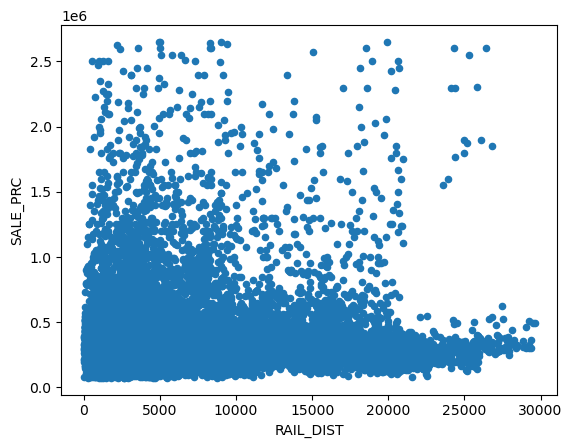

In [257]:
prices.plot(kind = 'scatter', x = 'RAIL_DIST', y = 'SALE_PRC')

There seems to be some correlation here so I will keep this field for now. <br><br>

I believe we have gotten rid of all the fields that will not yield much information. However, let's plot land area, living area, special features value, and water distance to ensure there is some correlation before proceeding.

<Axes: xlabel='LND_SQFOOT', ylabel='SALE_PRC'>

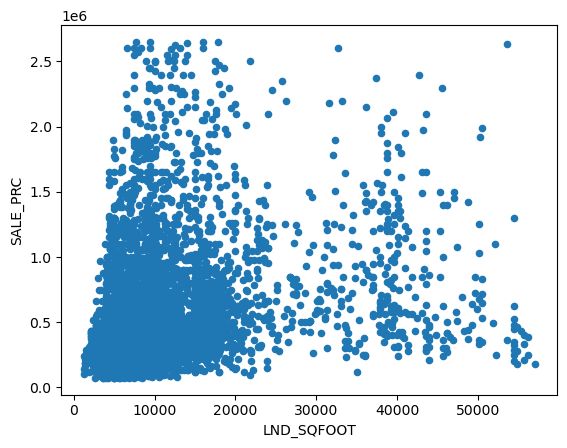

In [258]:
prices.plot(kind = 'scatter', x = 'LND_SQFOOT', y = 'SALE_PRC')

<Axes: xlabel='TOT_LVG_AREA', ylabel='SALE_PRC'>

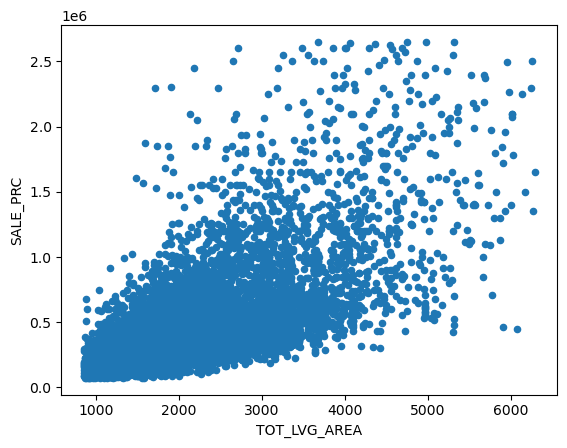

In [259]:
prices.plot(kind = 'scatter', x = 'TOT_LVG_AREA', y = 'SALE_PRC')

<Axes: xlabel='SPEC_FEAT_VAL', ylabel='SALE_PRC'>

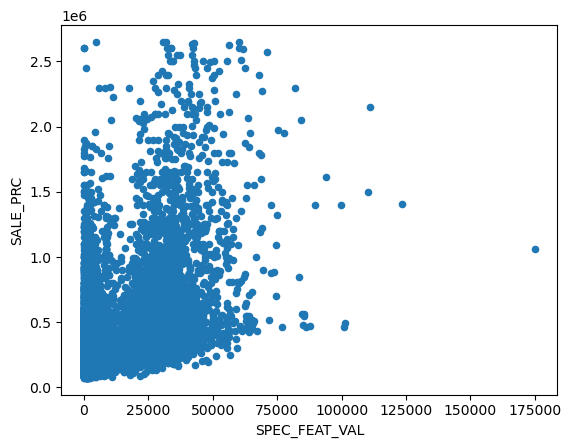

In [260]:
prices.plot(kind = 'scatter', x = 'SPEC_FEAT_VAL', y = 'SALE_PRC')

<Axes: xlabel='WATER_DIST', ylabel='SALE_PRC'>

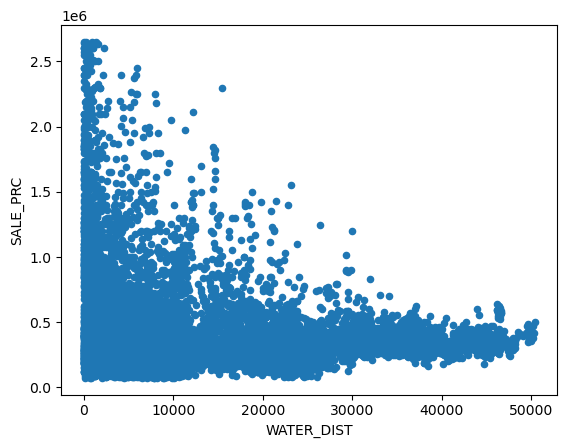

In [261]:
prices.plot(kind = 'scatter', x = 'WATER_DIST', y = 'SALE_PRC')

I will keep all of these fields for now.

### Part 2. Removing Outliers

First, I will remove all rows that are categoriezed as having a structure quality of 3. As we discovered in Part 1, this group is unusual in several regards.

In [262]:
prices.head()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,age,structure_quality
0,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,67,4
1,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,63,4
2,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,61,4
3,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,63,4
4,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,42,4


In [263]:
prices = prices[prices.structure_quality != 3]

In [264]:
prices[['structure_quality']].value_counts()

structure_quality
4                    7625
2                    4110
5                    2002
1                     179
dtype: int64

As you can see, we have successfully dropped all the rows that had a structure_quality value of 3. 

Next, we will remove outliers for all of the fields. I will start with sale price and check for outliers before and after to ensure the method works before applying it to all fields. I prefer to do this manually because it should not be that hard and I find a lot of the solutions presented online to be confusing. 

In [265]:
prices[['SALE_PRC']].describe()

,SALE_PRC
count,1.391600e+04
mean,3.982779e+05
std,3.127086e+05
min,7.200000e+04
25%,2.350000e+05
50%,3.100000e+05
75%,4.260000e+05
max,2.650000e+06


In [266]:
upper = prices[['SALE_PRC']].mean() + 3 * prices[['SALE_PRC']].std()
print(upper)

SALE_PRC    1.336404e+06
dtype: float64


In [267]:
lower = prices[['SALE_PRC']].mean() - 3 * prices[['SALE_PRC']].std()
print(lower)

SALE_PRC   -539847.874485
dtype: float64


Again, I will get a count of the outliers before and after attempting to remove them to check if this method works:

In [268]:
import numpy as np
(prices['SALE_PRC'] >= int(upper)).sum()

354

In [269]:
(prices['SALE_PRC'] <= int(lower)).sum()

0

In [270]:
prices.drop(prices[prices['SALE_PRC'] >= int(upper)].index, inplace = True)
(prices['SALE_PRC'] >= int(upper)).sum()

C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\4157542512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['SALE_PRC'] >= int(upper)].index, inplace = True)


0

This looks like it worked, although it required dropping a large number of rows. Hopefully other columns will have fewer outliers but we will see. I also expect that as outliers are removed based on certain columns, this will probably result in less outliers in other columns, and therefore as I remove them from each column, there will be fewer removed each time. Since I have confirmed that this method works, I will group more code per cell going forward. <br><br>
<b>NOTE:</b> After reopening my Jupyter Notebook and resuming my project, I am getting "SettingwithCopy" warnings here that I was not getting before. I have spent some time unsuccessfully trying to resolve these. However, it looks like the outliers are dropped as intended based on the before/after print statements, so I will proceed.

In [271]:
#Find range beyond which values will be considered outliers. I will use 3 SD from the mean.
#Note: There is probably a way to do this with a loop but I am not that comfortable with Python so I will
#do it manually. Troubleshooting various steps in this project is already taking much longer
#than I anticipated.
upper = prices[['LND_SQFOOT']].mean() + 3 * prices[['LND_SQFOOT']].std()
print("Upper limit: " + str(upper))

lower = prices[['LND_SQFOOT']].mean() - 3 * prices[['LND_SQFOOT']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['LND_SQFOOT'] >= int(upper)).sum())
print((prices['LND_SQFOOT'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['LND_SQFOOT'] >= int(upper)].index, inplace = True)
print((prices['LND_SQFOOT'] >= int(upper)).sum())
prices.drop(prices[prices['LND_SQFOOT'] >= int(upper)].index, inplace = True)
print((prices['LND_SQFOOT'] >= int(upper)).sum())

Upper limit: LND_SQFOOT    25602.514646
dtype: float64
Lower limit: LND_SQFOOT   -8766.378088
dtype: float64
Number of upper and lower outliers:
276
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\2305258202.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['LND_SQFOOT'] >= int(upper)].index, inplace = True)
C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\2305258202.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['LND_SQFOOT'] >= int(upper)].index, inplace = True)


In [272]:
#Total Living Area Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['TOT_LVG_AREA']].mean() + 3 * prices[['TOT_LVG_AREA']].std()
print("Upper limit: " + str(upper))

lower = prices[['TOT_LVG_AREA']].mean() - 3 * prices[['TOT_LVG_AREA']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['TOT_LVG_AREA'] >= int(upper)).sum())
print((prices['TOT_LVG_AREA'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['TOT_LVG_AREA'] >= int(upper)].index, inplace = True)
print((prices['TOT_LVG_AREA'] >= int(upper)).sum())
prices.drop(prices[prices['TOT_LVG_AREA'] >= int(upper)].index, inplace = True)
print((prices['TOT_LVG_AREA'] >= int(upper)).sum())

Upper limit: TOT_LVG_AREA    4107.932813
dtype: float64
Lower limit: TOT_LVG_AREA   -146.136336
dtype: float64
Number of upper and lower outliers:
142
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\706727073.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['TOT_LVG_AREA'] >= int(upper)].index, inplace = True)
C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\706727073.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['TOT_LVG_AREA'] >= int(upper)].index, inplace = True)


In [273]:
#Special Features Value:

#Find range beyond which values will be considered outliers.
upper = prices[['SPEC_FEAT_VAL']].mean() + 3 * prices[['SPEC_FEAT_VAL']].std()
print("Upper limit: " + str(upper))

lower = prices[['SPEC_FEAT_VAL']].mean() - 3 * prices[['SPEC_FEAT_VAL']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['SPEC_FEAT_VAL'] >= int(upper)).sum())
print((prices['SPEC_FEAT_VAL'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['SPEC_FEAT_VAL'] >= int(upper)].index, inplace = True)
print((prices['SPEC_FEAT_VAL'] >= int(upper)).sum())
prices.drop(prices[prices['SPEC_FEAT_VAL'] >= int(upper)].index, inplace = True)
print((prices['SPEC_FEAT_VAL'] >= int(upper)).sum())

Upper limit: SPEC_FEAT_VAL    45056.380982
dtype: float64
Lower limit: SPEC_FEAT_VAL   -28416.312358
dtype: float64
Number of upper and lower outliers:
166
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\1320543612.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['SPEC_FEAT_VAL'] >= int(upper)].index, inplace = True)
C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\1320543612.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['SPEC_FEAT_VAL'] >= int(upper)].index, inplace = True)


In [274]:
#Rail Distance Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['RAIL_DIST']].mean() + 3 * prices[['RAIL_DIST']].std()
print("Upper limit: " + str(upper))

lower = prices[['RAIL_DIST']].mean() - 3 * prices[['RAIL_DIST']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['RAIL_DIST'] >= int(upper)).sum())
print((prices['RAIL_DIST'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['RAIL_DIST'] >= int(upper)].index, inplace = True)
print((prices['RAIL_DIST'] >= int(upper)).sum())
prices.drop(prices[prices['RAIL_DIST'] >= int(upper)].index, inplace = True)
print((prices['RAIL_DIST'] >= int(upper)).sum())

Upper limit: RAIL_DIST    26979.678174
dtype: float64
Lower limit: RAIL_DIST   -10251.042052
dtype: float64
Number of upper and lower outliers:
44
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\1930373543.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['RAIL_DIST'] >= int(upper)].index, inplace = True)
C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\1930373543.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['RAIL_DIST'] >= int(upper)].index, inplace = True)


In [275]:
#Ocean Distance Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['OCEAN_DIST']].mean() + 3 * prices[['OCEAN_DIST']].std()
print("Upper limit: " + str(upper))

lower = prices[['OCEAN_DIST']].mean() - 3 * prices[['OCEAN_DIST']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['OCEAN_DIST'] >= int(upper)).sum())
print((prices['OCEAN_DIST'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['OCEAN_DIST'] >= int(upper)].index, inplace = True)
print((prices['OCEAN_DIST'] >= int(upper)).sum())
prices.drop(prices[prices['OCEAN_DIST'] >= int(upper)].index, inplace = True)
print((prices['OCEAN_DIST'] >= int(upper)).sum())

Upper limit: OCEAN_DIST    83531.8925
dtype: float64
Lower limit: OCEAN_DIST   -19208.327137
dtype: float64
Number of upper and lower outliers:
0
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\2515317496.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['OCEAN_DIST'] >= int(upper)].index, inplace = True)
C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\2515317496.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['OCEAN_DIST'] >= int(upper)].index, inplace = True)


In [276]:
#Water Distance Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['WATER_DIST']].mean() + 3 * prices[['WATER_DIST']].std()
print("Upper limit: " + str(upper))

lower = prices[['WATER_DIST']].mean() - 3 * prices[['WATER_DIST']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['WATER_DIST'] >= int(upper)).sum())
print((prices['WATER_DIST'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['WATER_DIST'] >= int(upper)].index, inplace = True)
print((prices['WATER_DIST'] >= int(upper)).sum())
prices.drop(prices[prices['WATER_DIST'] >= int(upper)].index, inplace = True)
print((prices['WATER_DIST'] >= int(upper)).sum())

C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\214568410.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['WATER_DIST'] >= int(upper)].index, inplace = True)


Upper limit: WATER_DIST    48209.31592
dtype: float64
Lower limit: WATER_DIST   -23910.267876
dtype: float64
Number of upper and lower outliers:
22
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\214568410.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['WATER_DIST'] >= int(upper)].index, inplace = True)


In [277]:
#City Distance Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['CNTR_DIST']].mean() + 3 * prices[['CNTR_DIST']].std()
print("Upper limit: " + str(upper))

lower = prices[['CNTR_DIST']].mean() - 3 * prices[['CNTR_DIST']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['CNTR_DIST'] >= int(upper)).sum())
print((prices['CNTR_DIST'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['CNTR_DIST'] >= int(upper)].index, inplace = True)
print((prices['CNTR_DIST'] >= int(upper)).sum())
prices.drop(prices[prices['CNTR_DIST'] >= int(upper)].index, inplace = True)
print((prices['CNTR_DIST'] >= int(upper)).sum())

C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\4194447047.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['CNTR_DIST'] >= int(upper)].index, inplace = True)


Upper limit: CNTR_DIST    165463.417072
dtype: float64
Lower limit: CNTR_DIST   -27409.436574
dtype: float64
Number of upper and lower outliers:
0
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\4194447047.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['CNTR_DIST'] >= int(upper)].index, inplace = True)


In [278]:
#Subcenter Distance Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['SUBCNTR_DI']].mean() + 3 * prices[['SUBCNTR_DI']].std()
print("Upper limit: " + str(upper))

lower = prices[['SUBCNTR_DI']].mean() - 3 * prices[['SUBCNTR_DI']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['SUBCNTR_DI'] >= int(upper)).sum())
print((prices['SUBCNTR_DI'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['SUBCNTR_DI'] >= int(upper)].index, inplace = True)
print((prices['SUBCNTR_DI'] >= int(upper)).sum())
prices.drop(prices[prices['SUBCNTR_DI'] >= int(upper)].index, inplace = True)
print((prices['SUBCNTR_DI'] >= int(upper)).sum())

C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\943405913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['SUBCNTR_DI'] >= int(upper)].index, inplace = True)


Upper limit: SUBCNTR_DI    107313.353134
dtype: float64
Lower limit: SUBCNTR_DI   -23624.825253
dtype: float64
Number of upper and lower outliers:
15
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\943405913.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['SUBCNTR_DI'] >= int(upper)].index, inplace = True)


In [279]:
#Age Outliers:

#Find range beyond which values will be considered outliers.
upper = prices[['age']].mean() + 3 * prices[['age']].std()
print("Upper limit: " + str(upper))

lower = prices[['age']].mean() - 3 * prices[['age']].std()
print("Lower limit: " + str(lower))

#Get counts of outliers before removing them:
print("Number of upper and lower outliers:")
print((prices['age'] >= int(upper)).sum())
print((prices['age'] <= int(lower)).sum())

#Attempt to remove outliers and print again:
print("Number of upper and lower outliers after attempting to remove:")
prices.drop(prices[prices['age'] >= int(upper)].index, inplace = True)
print((prices['age'] >= int(upper)).sum())
prices.drop(prices[prices['age'] >= int(upper)].index, inplace = True)
print((prices['age'] >= int(upper)).sum())

C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\647778076.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['age'] >= int(upper)].index, inplace = True)


Upper limit: age    95.070284
dtype: float64
Lower limit: age   -32.686939
dtype: float64
Number of upper and lower outliers:
3
0
Number of upper and lower outliers after attempting to remove:
0
0


C:\Users\khaml\AppData\Local\Temp\ipykernel_26724\647778076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.drop(prices[prices['age'] >= int(upper)].index, inplace = True)


In [280]:
#Let's see how many rows we have left:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12894 entries, 0 to 13931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SALE_PRC           12894 non-null  float64
 1   LND_SQFOOT         12894 non-null  int64  
 2   TOT_LVG_AREA       12894 non-null  int64  
 3   SPEC_FEAT_VAL      12894 non-null  int64  
 4   RAIL_DIST          12894 non-null  float64
 5   OCEAN_DIST         12894 non-null  float64
 6   WATER_DIST         12894 non-null  float64
 7   CNTR_DIST          12894 non-null  float64
 8   SUBCNTR_DI         12894 non-null  float64
 9   age                12894 non-null  int64  
 10  structure_quality  12894 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.2 MB


After removing outliers, we still have a lot of data left! Let's move on.

# 3. Normalizing Data
Although normalizing the data may not be strictly necessary with decision trees, they did this in the similar paper I read (see report). Therefore, I will also normalize my data. <br><br>


In [281]:
from sklearn.preprocessing import StandardScaler
column_names = ['LND_SQFOOT', 'TOT_LVG_AREA', 'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST', 'CNTR_DIST',
               'SUBCNTR_DI', 'age', 'structure_quality']
lnd_sqfoot_z = StandardScaler().fit_transform(prices[['LND_SQFOOT']])
tot_lvg_area_z = StandardScaler().fit_transform(prices[['TOT_LVG_AREA']])
spec_feat_val_z = StandardScaler().fit_transform(prices[['SPEC_FEAT_VAL']])
rail_dist_z = StandardScaler().fit_transform(prices[['RAIL_DIST']])
ocean_dist_z = StandardScaler().fit_transform(prices[['OCEAN_DIST']])
water_dist_z = StandardScaler().fit_transform(prices[['WATER_DIST']])
cntr_dist_z = StandardScaler().fit_transform(prices[['CNTR_DIST']])
subcntr_di_z = StandardScaler().fit_transform(prices[['SUBCNTR_DI']])
age_z = StandardScaler().fit_transform(prices[['age']])


In [282]:
# Start with one column to see if replacing the column works as expected:
prices_z = prices.copy()
prices_z[column_names[0]] = lnd_sqfoot_z
prices_z.head()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,age,structure_quality
0,440000.0,0.506945,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,67,4
1,349000.0,0.506945,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,63,4
3,988000.0,1.423422,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,63,4
4,755000.0,1.527736,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,42,4
5,630000.0,0.663417,1531,2978,2391.4,13017.0,188.9,43135.1,38176.2,41,4


In [283]:
prices_z[column_names[1]] = tot_lvg_area_z
prices_z[column_names[2]] = spec_feat_val_z
prices_z[column_names[3]] = rail_dist_z
prices_z[column_names[4]] = ocean_dist_z
prices_z[column_names[5]] = water_dist_z
prices_z[column_names[6]] = cntr_dist_z
prices_z[column_names[7]] = subcntr_di_z
prices_z[column_names[8]] = age_z


In [284]:
prices_z.head()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,age,structure_quality
0,440000.0,0.506945,-0.288533,-0.692636,-0.897983,-1.127968,-0.982872,-0.815879,-0.185658,1.684099,4
1,349000.0,0.506945,-0.347087,-0.692636,-0.645543,-1.254472,-0.983693,-0.794339,-0.204157,1.496054,4
3,988000.0,1.423422,0.181435,0.203536,-0.608590,-1.283240,-1.012001,-0.785200,-0.200349,1.496054,4
4,755000.0,1.527736,-0.394854,0.797352,-0.693914,-1.243453,-0.984632,-0.791378,-0.194473,0.508821,4
5,630000.0,0.663417,-0.630608,-0.426634,-0.967423,-1.115944,-0.996171,-0.805890,-0.165672,0.461809,4


# 4. Split Training and Test Data

In [285]:
# Isolate the dependent variable:
response = 'SALE_PRC'
y = prices_z[[response]]
y

,SALE_PRC
0,440000.0
1,349000.0
3,988000.0
4,755000.0
5,630000.0
...,...
13927,275000.0
13928,340000.0
13929,287500.0
13930,315000.0


In [286]:
# Isolate independent variables:
predictors = list(prices_z.columns)
predictors.remove(response)
x = prices_z[predictors]
x

,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,age,structure_quality
0,0.506945,-0.288533,-0.692636,-0.897983,-1.127968,-0.982872,-0.815879,-0.185658,1.684099,4
1,0.506945,-0.347087,-0.692636,-0.645543,-1.254472,-0.983693,-0.794339,-0.204157,1.496054,4
3,1.423422,0.181435,0.203536,-0.608590,-1.283240,-1.012001,-0.785200,-0.200349,1.496054,4
4,1.527736,-0.394854,0.797352,-0.693914,-1.243453,-0.984632,-0.791378,-0.194473,0.508821,4
5,0.663417,-0.630608,-0.426634,-0.967423,-1.115944,-0.996171,-0.805890,-0.165672,0.461809,4
...,...,...,...,...,...,...,...,...,...,...
13927,-0.266471,-1.499664,-0.104894,-0.729722,-0.674323,-0.739445,-1.460558,-1.364209,-0.713469,4
13928,-0.051882,-0.132904,-0.465400,-0.770765,-0.661228,-0.754085,-1.454336,-1.356532,-0.243358,4
13929,0.234238,-1.031237,-0.508274,-0.680860,-0.689535,-0.711288,-1.498322,-1.351181,-0.713469,4
13930,-0.051882,-0.504256,-0.412521,-0.706428,-0.675808,-0.711229,-1.482432,-1.350030,-0.713469,4


In [287]:
# Use the train_test_split function to split the data:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
x_test.shape

(2579, 10)

The x_test dataframe has 20% of the original rows, as expected.

# 5. Training the Model

In [288]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [289]:
dt_model = DecisionTreeRegressor(random_state = 0)
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

# 6. Evaluate the Model
To evaluate the model, I will look at the mean absolute error and the r^2 value. This is easier to interpret than the squared mean error because since it is not squared, we will understand approximately how off the estimates of the model tend to be. 

In [300]:
# Predict the output for the training data:
y_pred = dt_model.predict(x_test)
y_pred

array([482000., 460000., 309900., ..., 335000., 278500., 275000.])

In [305]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae

52870.34587049244

In [302]:
dt_model.score(x_test, y_test)

0.783277114567881

In [303]:
columns = x_train.columns
importance = dt_model.feature_importances_
feature_importances = pd.Series(importance, columns)
feature_importances

LND_SQFOOT           0.036011
TOT_LVG_AREA         0.325783
SPEC_FEAT_VAL        0.017745
RAIL_DIST            0.023678
OCEAN_DIST           0.135869
WATER_DIST           0.056713
CNTR_DIST            0.080773
SUBCNTR_DI           0.099294
age                  0.025905
structure_quality    0.198230
dtype: float64

<Axes: >

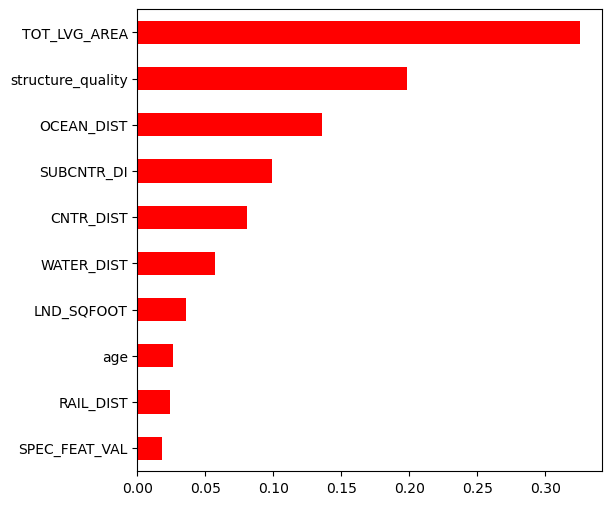

In [304]:
from matplotlib.pyplot import figure
figure(figsize=(6,6))
feature_importances.sort_values().plot.barh(color='red')

The feature_importance from the decision tree regressor model tells us comparatively how much each input affects the regression model. I am very surprised that structure quality has such a high value.

In [306]:
y_test[['SALE_PRC']].describe()

,SALE_PRC
count,2.579000e+03
mean,3.477718e+05
std,1.939079e+05
min,7.200000e+04
25%,2.300000e+05
50%,3.000000e+05
75%,4.000000e+05
max,1.330000e+06


In [308]:
std = y_test[['SALE_PRC']].std()

In [309]:
print('The mean absolute error of the test data for our model is: ' + str(mae))
print('The standard deviation of the prices in our test data is: ' + str(std))
print('The mean absolute error divided by the std is: ' + str(mae/std))

The mean absolute error of the test data for our model is: 52870.34587049244
The standard deviation of the prices in our test data is: SALE_PRC    193907.87198
dtype: float64
The mean absolute error divided by the std is: SALE_PRC    0.272657
dtype: float64


Initially, I thought an error of $52,000 was quite high. However, knowing that the standard deviation of the prices is so large, I actually feel that this mean absolute error is not bad. Please see my report for further discussion. 

# 7. References
Unknown. (No Date) Miami Housing Dataset. Retrieved June 29, 2023. from https://www.kaggle.com/datasets/deepcontractor/miami-housing-dataset. <br><br>
Nwanganga, F. (2021). Machine Learning with Python: Foundations [Course]. LinkedIn Learning. https://www.linkedin.com/learning/machine-learning-with-python-foundations <br><br>
Krishnan, Sandhya. (2021). Decision Tree for Classification, Entropy, and Information Gain. Retrieved July 16, 2023. from https://medium.com/codex/decision-tree-for-classification-entropy-and-information-gain-cd9f99a26e0d<br><br>
EvidenceN. (2021) How to Interpret Decision Tree Regressor Model Resutls in Python, Scikit-Learn, Matplotlib. Retrieved July 17, 2023 from https://youtu.be/z9GDlJs1qDA